The aim of this notebook is to act as a central hub, within which all of the detectors presented in the supporting notebooks are directly compared.

In [1]:
# First, imports
import numpy as np
import pandas as pd
from sklearn.metrics import roc_curve
# for Manhattan detector, need cityblock distance
from scipy.spatial.distance import cityblock
from itertools import zip_longest
# for plot formatting
import matplotlib.pyplot as plt
import matplotlib.lines as mlines

In [2]:
# Read in csv file and check what's inside
df = pd.read_csv('DSL-StrongPasswordData.csv')
subjects = df["subject"].unique()

In [3]:
# Define a general Manhattan class capable of producing various models

# Variables:
# name - string - name of model
# df - the dataframe 
# subjects - unique subjects within the dataframe
# useFilter - boolean - controls whether to apply a filter to the training vector
# featExclRegex - string - regex through which features in the dataframe can be excluded from training
# plotCol - string - colour to use when plotting this detector's performance
# mean_vector - np.array(float) - mean values of training data
# user_dists - list(float) - cityblock distances computed while testing on genuine user data
# imposter_dists - list(float) - cityblock distances computed while testing on imposter user data
# eer_list - list(float) - contains eer of each model iteration
# eer_average - float - model average eer
# eer_average_std - float - model average eer std deviation
# fpr_thresh - np.array(float) - fixed list of fpr values from which interpolated tpr values can be calculated (roc_curve returns fpr/tpr lists of differing length between iterations)
# interp_tpr_lst - list(float) - interpolated tpr values (calculated wrt fpr_thresh)
# tpr_lower - np.array(float) - interp_tpr_list.mean - interp_tpr_list.stddev
# tpr_upper - np.array(float) - interp_tpr_list.mean + interp_tpr_list.stddev
# training_data - df - data used to train model
# genuine_user_data - df - genuine user data used to test model
# imposter_user_data - df - genuine imposter data used to test model


class Manhattan:
    def __init__(self, name, df, useFilter, featExclRegex, plotCol):
        self.name = name
        self.df = df
        self.subjects = df["subject"].unique()
        self.useFilter = useFilter
        self.featExclRegex = featExclRegex
        self.plotCol = plotCol
        self.mean_vector = []
        self.user_dists = []
        self.imposter_dists = []
        self.eer_list = []
        self.eer_average = 0.
        self.eer_average_std= 0.
        self.fpr_thresh = np.linspace(0,1,201)
        self.interp_tpr_lst = []
        self.tpr_lower = []
        self.tpr_upper = []
        # We lazily initialise these dataframes to the main one
        # This is to avoid defining these class variables in a function other than __init__ (which isn't something I like)
        self.training_data = df
        self.genuine_user_data = df
        self.imposter_user_data = df
            
    def train(self):
        self.mean_vector = self.training_data.mean().values
        
        if self.useFilter == True:
            std_vector = self.training_data.std().values
            # Remove values that are +/- 3 std dev from the mean, and form a robust mean vector from those left
            drop_indices = []
    
            for row in range(self.training_data.shape[0]):
                for feature in range(self.training_data.shape[1]):
                    if self.training_data.iloc[row].iloc[feature] > (self.mean_vector[feature]+3*std_vector[feature]) or self.training_data.iloc[row].iloc[feature] < (self.mean_vector[feature]-3*std_vector[feature]):
                        drop_indices.append(row)
                        break
            self.training_data = self.training_data.drop(self.training_data.index[drop_indices])
            self.mean_vector = self.training_data.mean().values  
        
        
    def test(self):
        # for each row (entry), compute cityblock distance between mean vector and test vector
        for i in range(self.genuine_user_data.shape[0]):
            dist = cityblock(self.genuine_user_data.iloc[i].values, self.mean_vector)
            self.user_dists.append(dist)
        for i in range(self.imposter_user_data.shape[0]):
            dist = cityblock(self.imposter_user_data.iloc[i].values, self.mean_vector)
            self.imposter_dists.append(dist)
        
    
    def evaluate(self):
        for subject in self.subjects:
            real_user = self.df.loc[self.df.subject == subject]
            fake_user = self.df.loc[self.df.subject != subject]
            
            self.training_data = real_user[:200].loc[:, 'H.period':'H.Return']

            # To test our model, we need both more data from the original user, and imposter user data
            self.genuine_user_data = real_user[200:].loc[:, 'H.period':'H.Return']

            self.imposter_user_data = fake_user[:].loc[:, 'H.period':'H.Return']
    
            if self.featExclRegex != "":
                self.training_data.drop(list(self.training_data.filter(regex = self.featExclRegex)), axis = 1, inplace = True)
                self.genuine_user_data.drop(list(self.genuine_user_data.filter(regex = self.featExclRegex)), axis = 1, inplace = True)
                self.imposter_user_data.drop(list(self.imposter_user_data.filter(regex = self.featExclRegex)), axis = 1, inplace = True)
    
            # Let's check dimensions of our training and testing tuples are the same...just in case
            if self.training_data.shape != self.genuine_user_data.shape:
                sys.exit("training_data and genuine_user_data shapes don't match: {} | {}".format(self.training_data.shape, self.genuine_user_data.shape))
            elif self.imposter_user_data.shape[0] != self.genuine_user_data.shape[0]*100:
                sys.exit("imposter_user_data and genuine_user_data rows aren't 20000 and 200: {} | {}".format(self.imposter_user_data.shape[0], self.genuine_user_data.shape[0]))

            self.train()
            self.test()
            
            # Time to compute equal error rates
            # Labels: 0 = user, 1 = imposter. We therefore need np arrays of 0s and 1s to same length as NSamples
            labels = [0]*len(self.user_dists) + [1]*len(self.imposter_dists)
            fpr, tpr, thresholds = roc_curve(labels, self.user_dists + self.imposter_dists) 

            # TPR = TP / (TP + FN) i.e. over total positives that shouldve been identified as true
            # FPR = FP / (FP + TN) i.e. over total negatives that shouldve been identified as true
            # TPR + FNR = 1
            # FPR + TNR = 1
            fnr = 1 - tpr
    
            # Equal error rate is where fnr = fpr (or minimum distance between them)      
            # So we calculate the absolute difference between fnr and fpr and find where that's minimised
            # Small differences are present depending on whether we do fnr[] or fpr[] as we aren't interpolating
            eer = fnr[np.nanargmin(np.absolute(fnr-fpr))]
            self.eer_list.append(eer)
    
            # Interpolate tpr values for this roc iteration, store in list
            self.interp_tpr_lst.append(np.interp(self.fpr_thresh,fpr,tpr))
            
        mean_tpr = np.mean(self.interp_tpr_lst,axis=0)
        std_tpr = np.std(self.interp_tpr_lst,axis=0)
        # for error bar propagation
        self.tpr_upper = np.minimum(mean_tpr + std_tpr, 1)
        self.tpr_lower = mean_tpr - std_tpr
        
        self.eer_average = np.mean(self.eer_list)
        self.eer_average_std = np.std(self.eer_list, ddof=0)
    
    def calc_percent_improve(self,nominal):
        return (nominal.eer_average-self.eer_average)/nominal.eer_average*100
    
    def output_values(self,nominal):
        print("%s | %.3f | %.3f | %.3f" % (self.name, self.eer_average, self.eer_average_std, self.calc_percent_improve(nominal)))

In [4]:
# Define model instances
detector_list = []

manhattan = Manhattan('Manhattan',df,False,"",'red')
manhattanNoH = Manhattan('ManhattanNoH',df,False,"H",'green')
manhattanNoUD = Manhattan('ManhattanNoUD',df,False,"UD",'purple')
manhattanNoDD = Manhattan('ManhattanNoDD',df,False,"DD",'orange')
manhattanFiltered = Manhattan('ManhattanFiltered',df,True,"",'blue')
manhattanFilteredNoUD = Manhattan('ManhattanFilteredNoUD',df,True,"UD",'gold')

detector_list.append(manhattan)
detector_list.append(manhattanNoH)
detector_list.append(manhattanNoUD)
detector_list.append(manhattanNoDD)
detector_list.append(manhattanFiltered)
detector_list.append(manhattanFilteredNoUD)

In [5]:
# Evaluate models
print("Detector | Average EER | Average EER Std Dev | % Improvement vs Nominal")
for det in detector_list:
    det.evaluate()
    det.output_values(detector_list[0]) #detector_list[0] is nominal - used for % improvement calc

Detector | Average EER | Average EER Std Dev | % Improvement vs Nominal
Manhattan | 0.299 | 0.016 | 0.000
ManhattanNoH | 0.332 | 0.017 | -10.961
ManhattanNoUD | 0.270 | 0.013 | 9.871
ManhattanNoDD | 0.283 | 0.020 | 5.281
ManhattanFiltered | 0.255 | 0.016 | 14.629
ManhattanFilteredNoUD | 0.237 | 0.017 | 20.786


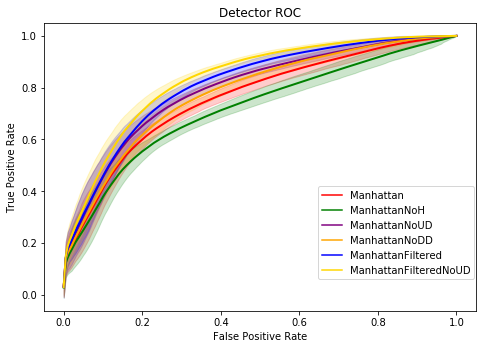

In [10]:
# Plot ROCs of different models
# This is obviously a lot of copy paste - plan to refactor into a function ASAP
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.set_title('Detector ROC')
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')

leg_list = []

for det in detector_list:
    ax.plot(det.fpr_thresh,np.mean(det.interp_tpr_lst,axis=0),det.plotCol,ls='-',lw=2,label=det.name)
    ax.fill_between(det.fpr_thresh, det.tpr_lower, det.tpr_upper, color=det.plotCol, alpha=0.2)
    leg = mlines.Line2D([],[],color=det.plotCol,linestyle="-",label=det.name)
    leg_list.append(leg)

fig.legend(loc=[0.65,0.2],handles=leg_list)

# Conclusion and Future Improvements
Things that could be looked at in future:
- Try multi-class classification vs anomaly detection.
    - Rather than training with respect to one user's data, then testing against the rest, with MCC you could use multiple user's samples to form decision boundaries wherein users could be distinguished.
- Determine whether other features present in the data could be filtered out before training - are there particular keys that better distinguish different users?
- Could implement hypothesis testing to verify our model is better than the others presented (rather than due to just random chance).
- Could look at other keystroke data available online (as mentioned in the paper) - although if we were to integrate it, we'd have to ensure it was recorded under similar conditions.